<center><img src="https://arokem.github.io/2015-ohbm-dipy-short/images/dipy-logo.png" width="50%"></center>

# Structural connectivity and diffusion imaging

Structural connectivity or diffusion imaging can be studied in many different way. [`Dipy`](http://nipy.org/dipy/) is only one of them. [`Dipy`](http://nipy.org/dipy/) is focusing mainly on diffusion magnetic resonance imaging (dMRI) analysis and implements a broad range of algorithms for denoising, registration, reconstruction, tracking, clustering, visualization, and statistical analysis of dMRI data. For a more detailed guide and a lot of examples go to [`Dipy`](http://nipy.org/dipy/), here we want to show you just a few basics.

Speaking of which, we will be covering the following sections:

1. Reconstruction of the diffusion signal with the Tensor model
1. Other reconstruction approaches, such as sparse fascicle models (SFM)
1. Introduction to Tractography
1. Using Various Tissue Classifiers for Tractography
1. Connectivity Matrices, ROI Intersections, and Density Maps
1. Direct Bundle Registration

**General disclaimer**: This notebook was written by somebody who is not an expert in diffusion imaging analysis. Therefore, certain steps might not be useful or not used in an actual analysis. Keep this in mind while going through this notebook.

**<span style="color:red">Important:</span>** The rendering of the diffusion images is this notebook is not possible if you run the notebook within a docker container. For this reason, all output figures were already precomputed and can be shown nonetheless. If you're running the noteobook outside of a docker container you can set the variable `view_mode` to `'create_plot'` to create plots or to `'interactive'` to interactively manipulate the 3D rendered images.

In [80]:
view_mode = 'interactive'

# Setup

Before we start with anything, let's setup the important plotting functions:

In [2]:
from nilearn import plotting
%matplotlib inline
import matplotlib.pyplot as plt
import nibabel as nb
import numpy as np
from IPython.display import Image

# Explore the tutorial dataset

For this tutorial, we will be using the **Stanford HARDI** dataset, provided with Dipy. You can download the required datasets with the following commands:
```python
from dipy.data import (read_stanford_labels, read_stanford_t1,
                       read_stanford_pve_maps)

img, gtab, labels_img = read_stanford_labels()
t1 = read_stanford_t1()
pve_csf, pve_gm, pve_wm = read_stanford_pve_maps()
```

To speed up this process, we've already downloaded the data for you and put it into the folder: `/data/diffusion/`

This means we can load all required files with the following commands:

In [5]:
t1 = nb.load('/opt/dora/Dora/BIDS_ELA/BIDS_ELA/derivatives/aslprep/aslprep/sub-C001/anat/sub-C001_desc-preproc_T1w.nii.gz')
pve_csf = nb.load('/opt/dora/Dora/BIDS_ELA/BIDS_ELA/derivatives/aslprep/aslprep/sub-C001/anat/sub-C001_label-CSF_probseg.nii.gz')
pve_gm = nb.load('/opt/dora/Dora/BIDS_ELA/BIDS_ELA/derivatives/aslprep/aslprep/sub-C001/anat/sub-C001_label-GM_probseg.nii.gz')
pve_wm = nb.load('/opt/dora/Dora/BIDS_ELA/BIDS_ELA/derivatives/aslprep/aslprep/sub-C001/anat/sub-C001_label-WM_probseg.nii.gz')
img = nb.load('/opt/dora/Dora/BIDS_ELA/BIDS_ELA/sub-C001/dwi/sub-C001_run-1_dwi.nii.gz')
#labels_img = nb.load('data/diffusion/stanford_hardi/HARDI150_labels.nii.gz')

So what do we have?

In [6]:
axial_middle = img.shape[2] // 2

Text(0.5, 1.0, 'Diffusion weights direc. 100')

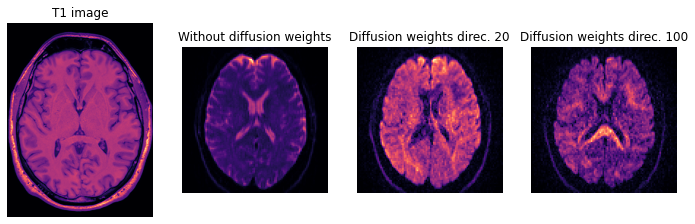

In [13]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 4, 1).set_axis_off()
plt.imshow(t1.get_fdata()[:, :, 150].T, cmap='magma', origin='lower')
plt.title('T1 image')

plt.subplot(1, 4, 2).set_axis_off()
plt.imshow(img.get_fdata()[:, :, axial_middle, 0].T, cmap='magma', origin='lower')
plt.title('Without diffusion weights')

plt.subplot(1, 4, 3).set_axis_off()
plt.imshow(img.get_fdata()[:, :, axial_middle, 30].T, cmap='magma', origin='lower')
plt.title('Diffusion weights direc. 20')

plt.subplot(1, 4, 4).set_axis_off()
plt.imshow(img.get_fdata()[:, :, axial_middle, 110].T, cmap='magma', origin='lower')
plt.title('Diffusion weights direc. 100')

Text(0.5, 1.0, 'WM segmentation')

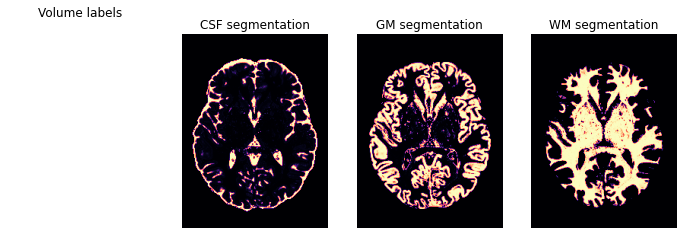

In [17]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 4, 1).set_axis_off()
#plt.imshow(labels_img.get_fdata()[:, :, axial_middle].T, cmap='nipy_spectral', origin='lower')
plt.title('Volume labels')

plt.subplot(1, 4, 2).set_axis_off()
plt.imshow(pve_csf.get_fdata()[:, :, 150].T, cmap='magma', origin='lower')
plt.title('CSF segmentation')

plt.subplot(1, 4, 3).set_axis_off()
plt.imshow(pve_gm.get_fdata()[:, :, 150].T, cmap='magma', origin='lower')
plt.title('GM segmentation')

plt.subplot(1, 4, 4).set_axis_off()
plt.imshow(pve_wm.get_fdata()[:, :, 150].T, cmap='magma', origin='lower')
plt.title('WM segmentation')

In diffusion MRI (dMRI) usually we use three types of files, a Nifti file with the diffusion weighted data (here `hardi_img.nii.gz`), and two text files one with b-values and one with the b-vectors. So let's also load those two files:

In [18]:
bvals = '/opt/dora/Dora/BIDS_ELA/BIDS_ELA/sub-C001/dwi/sub-C001_run-1_dwi.bval'
bvecs = '/opt/dora/Dora/BIDS_ELA/BIDS_ELA/sub-C001/dwi/sub-C001_run-1_dwi.bvec'

from dipy.core.gradients import gradient_table
gtab = gradient_table(bvals, bvecs)

Using the GradientTable object `gtab` you can show some information about the acquisition parameters.

In [19]:
print(gtab.info)

B-values shape (140,)
         min 0.000000
         max 2000.000000
B-vectors shape (140, 3)
          min -0.999775
          max 0.997102

None


You can also see the b-values using:

In [20]:
print(gtab.bvals)

[   0. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.]


Or, for example the last 10 b-vectors using:

In [21]:
print(gtab.bvecs[-10:, :])

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


Now, that we learned how to load dMRI datasets we can start the analysis.

# Reconstruction of the diffusion signal with the Tensor model

The diffusion tensor model is a model that describes the diffusion within a voxel. In short, for each voxel, we can estimate a tensor that had orientation and a particular tensor shape that indicates the primary diffusion directions of water in this voxel. For more details, check out the [full example](http://nipy.org/dipy/examples_built/reconst_dti.html#example-reconst-dti) on the dipy homepage.

## Preparation

In [22]:
data = img.get_fdata()
print('data shape before masking: (%d, %d, %d, %d)' % data.shape)

data shape before masking: (100, 100, 66, 140)


To avoid the calculation of the Tensors in the background of the image, we first need to mask and crop the data. For this, we can use Dipy's mask module.

In [23]:
from dipy.segment.mask import median_otsu
maskdata, mask = median_otsu(data, vol_idx=range(10,50), median_radius=3, numpass=1, autocrop=True, dilate=2)
print('data shape after masking (%d, %d, %d, %d)' % maskdata.shape)

data shape after masking (75, 96, 63, 140)


## Tensor reconstruction

Now that we have prepared the datasets we can go forward with the voxel reconstruction. First, we instantiate the Tensor model in the following way.

In [24]:
import dipy.reconst.dti as dti
tenmodel = dti.TensorModel(gtab)

Now we can fit the data to the model. This is very simple. We just need to call the fit method of the `TensorModel` in the following way:

In [25]:
tenfit = tenmodel.fit(maskdata)

Now that we have the model fit, we can quickly extract the fractional anisotropy (FA) or the mean diffusivity (MD) from the eigenvalues of the tensor. FA is used to characterize the degree to which the distribution of diffusion in a voxel is directional. That is, whether there is relatively unrestricted diffusion in one particular direction. The MD is simply the mean of the eigenvalues of the tensor. Since FA is a normalized measure of variance and MD is the mean, they are often used as complementary measures.

In [26]:
from dipy.reconst.dti import fractional_anisotropy, mean_diffusivity

FA = fractional_anisotropy(tenfit.evals)
MD = mean_diffusivity(tenfit.evals)

So what do they look like?

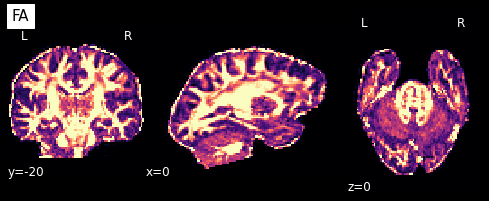

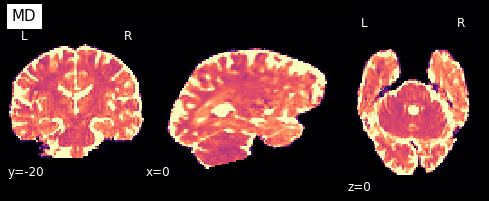

In [27]:
plotting.plot_anat(nb.Nifti1Image(FA, img.affine, img.header), cut_coords=[0,-20,0],
                   dim=-1, draw_cross=False, cmap='magma', title='FA')
plotting.plot_anat(nb.Nifti1Image(MD, img.affine, img.header), cut_coords=[0,-20,0],
                   dim=-1, draw_cross=False, cmap='magma', title='MD', vmax=0.001)

We can also compute the colored FA or RGB-map ([Pajevic et al., 1999](https://mscl.cit.nih.gov/mscl_publications/pierpaoli_99.pdf)). First, we make sure that the FA is scaled between 0 and 1, we compute the RGB map and save it.

In [28]:
from dipy.reconst.dti import color_fa
RGB = color_fa(FA, tenfit.evecs)

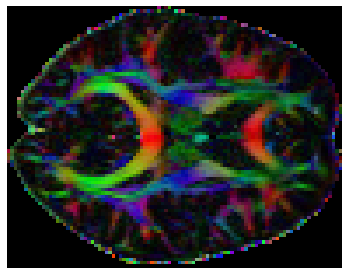

In [29]:
# Let's visualize this
plt.figure(figsize=(6, 6))
plt.imshow(RGB[:, :, 31,:])
plt.axis('off');

## Tensor visualization

We've estimated the tensors throughout the brain. Now, let’s try to visualize the tensor ellipsoids. For the visualization we need to load the sphere objects, define a canvas to plot the image (here a rendered window) and precut data to a small rectangular area in an axial slice of the splenium of the corpus callosum (CC).

In [30]:
from dipy.data import get_sphere
sphere = get_sphere('symmetric724')

In [31]:
evals = tenfit.evals[13:43, 44:74, 28:29]
evecs = tenfit.evecs[13:43, 44:74, 28:29]

We can color the ellipsoids using the `color_fa` values that we calculated above. In this example we additionally normalize the values to increase the contrast.

In [32]:
cfa = RGB[13:43, 44:74, 28:29]
cfa /= cfa.max() * 0.5

In [33]:
from dipy.viz import window, actor
ren = window.Scene()
ren.add(actor.tensor_slicer(evals, evecs, scalar_colors=cfa, sphere=sphere, scale=0.3))

In [34]:
if view_mode == 'create_plot':
    window.record(ren, n_frames=1, size=(600, 600),
                  out_path='data/diffusion/tensor_ellipsoids.png')
elif view_mode == 'interactive':
    window.show(ren)

In [36]:
#Image(filename='data/diffusion/tensor_ellipsoids.png')

Finally, we can also visualize the tensor Orientation Distribution Functions for the same area as we did with the ellipsoids.

In [37]:
tensor_odfs = tenmodel.fit(data[20:50, 55:85, 38:39]).odf(sphere)
odf_actor = actor.odf_slicer(tensor_odfs, sphere=sphere, scale=0.5, colormap=None)
ren.add(odf_actor)

In [38]:
if view_mode == 'create_plot':
    window.record(ren, n_frames=1, size=(600, 600),
                  out_path='data/diffusion/tensor_odfs.png')
elif view_mode == 'interactive':
    window.show(ren)

In [40]:
#Image(filename='data/diffusion/tensor_odfs.png')

Note that while the tensor model is an accurate and reliable model of the diffusion signal in the white matter, it has the drawback that it only has one principal diffusion direction. Therefore, in locations in the brain that contain multiple fiber populations crossing each other, the tensor model may indicate that the principal diffusion direction is intermediate to these directions. Therefore, using the principal diffusion direction for tracking in these locations may be misleading and may lead to errors in defining the tracks. Fortunately, other reconstruction methods can be used to represent the diffusion and fiber orientations in those locations.

# Other reconstruction approaches

Dipy offers many different reconstruction models, such as Constrained Spherical Deconvolution, Continuous Axially Symmetric Tensors, Q-Ball Constant Solid Angle, Sparse Fascicle Model and many more. For a full list check out the [Reconstruction section](http://nipy.org/dipy/examples_index.html#reconstruction) on dipy.org.

But to show you how easy it is to change the reconstruction model, let's take a loop at the **Sparse Fascicle Model** ([Rokem et al., 2015](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0123272)). In very short, sparse fascicle models (SFM) try to control for the noise due to variance, and over-fitting, by means of regularization by limiting the number of fascicles in the estimated solution.

## Create Model

Just like in Constrained Spherical Deconvolution (see [Reconstruction with Constrained Spherical Deconvolution](http://nipy.org/dipy/examples_built/reconst_csd.html#reconst-csd)), the SFM requires the definition of a response function. We'll take advantage of the automated algorithm in the `csdeconv` module to find this response function:

In [45]:
from dipy.reconst.csdeconv import (auto_response_ssst,
                                   mask_for_response_ssst,
                                   response_from_mask_ssst)

response, ratio = auto_response_ssst(gtab, data, roi_radii=10, fa_thr=0.7)

# from dipy.reconst.csdeconv import auto_response
# response, ratio = auto_response(gtab, data, roi_radius=10, fa_thr=0.7)

The `response` return value contains two entries. The first is an array with the eigenvalues of the response function and the second is the average S0 for this response. It is a very good practice to always validate the result of `auto_response`. For, this purpose we can print it and have a look at its values.

In [46]:
print(response)

(array([0.00157425, 0.00030957, 0.00030957]), 102.79310742277548)


We initialize an SFM model object, using these values. We will use the default sphere (362 vertices, symmetrically distributed on the surface of the sphere), as a set of putative fascicle directions that are considered in the model.

In [47]:
from dipy.data import get_sphere
sphere = get_sphere('symmetric362')

In [48]:
import dipy.reconst.sfm as sfm
sf_model = sfm.SparseFascicleModel(gtab, sphere=sphere,
                                   l1_ratio=0.5, alpha=0.001,
                                   response=response[0])

As before, let's focus on  the small volume of data containing parts of the corpus callosum and of the centrum semiovale.

In [49]:
data_small = data[20:50, 55:85, 38:39]

## Fit Model & Visualize results

Fitting the model to this small volume of data, we calculate the ODF of this model on the sphere and plot it.

In [50]:
sf_fit = sf_model.fit(data_small)
sf_odf = sf_fit.odf(sphere)

In [59]:
from dipy.viz import window, actor
ren = window.Scene()
fodf_spheres = actor.odf_slicer(sf_odf, sphere=sphere, scale=0.8, colormap='plasma')
ren.add(fodf_spheres)

In [81]:
if view_mode == 'create_plot':
    window.record(ren, size=(600, 600),
                  out_path='/home/quizhpilema.134643/sf_odfs.png')
elif view_mode == 'interactive':
    window.show(ren)

In [82]:
Image(filename='/home/quizhpilema.134643/sf_odfs.png')

FileNotFoundError: [Errno 2] No such file or directory: '/home/quizhpilema.134643/sf_odfs.png'

We can extract the peaks from the ODF, and plot these as well.

In [83]:
import dipy.direction.peaks as dpp
sf_peaks = dpp.peaks_from_model(sf_model,
                                data_small,
                                sphere,
                                relative_peak_threshold=.5,
                                min_separation_angle=25,
                                return_sh=False)

In [84]:
# Let's render these peaks as well
fodf_peaks = actor.peak_slicer(sf_peaks.peak_dirs, sf_peaks.peak_values)
ren.add(fodf_peaks)

In [85]:
if view_mode == 'create_plot':
    window.record(ren, size=(600, 600),
                  out_path='data/diffusion/sf_peaks.png')
elif view_mode == 'interactive':
    window.show(ren)

In [86]:
Image(filename='data/diffusion/sf_peaks.png')

FileNotFoundError: [Errno 2] No such file or directory: 'data/diffusion/sf_peaks.png'

Finally, we can plot both the peaks and the ODFs, overlayed:

In [87]:
fodf_spheres.GetProperty().SetOpacity(0.4)
ren.add(fodf_spheres)

In [88]:
if view_mode == 'create_plot':
    window.record(ren, size=(600, 600),
                  out_path='data/diffusion/sf_both.png')
elif view_mode == 'interactive':
    window.show(ren)

In [89]:
Image(filename='data/diffusion/sf_both.png')

FileNotFoundError: [Errno 2] No such file or directory: 'data/diffusion/sf_both.png'

# Introduction to Tractography

Local fiber tracking is an approach used to model white matter fibers by creating streamlines from local directional information. The idea is as follows: if the local directionality of a tract/pathway segment is known, one can integrate along those directions to build a complete representation of that structure. Local fiber tracking is widely used in the field of diffusion MRI because it is simple and robust.

In order to perform local fiber tracking, three things are needed:
1. A method for getting directions from a diffusion data set.
1. A method for identifying different tissue types within the data set.
1. A set of seeds from which to begin tracking.

Here we will use Constrained Spherical Deconvolution (CSD) [Tournier et al., 2007](https://www.sciencedirect.com/science/article/pii/S1053811907001243) for local reconstruction and then generate deterministic streamlines using the fiber directions (peaks) from CSD and fractional anisotropic (FA) from DTI as stopping criteria for the tracking. As before, we will be using the masked Stanford HARDI dataset.

## Estimate the response function and create a model

For the Constrained Spherical Deconvolution we need to estimate the response function (see Reconstruction with Constrained Spherical Deconvolution) and create a model.

In [68]:
from dipy.reconst.csdeconv import (auto_response_ssst,
                                   mask_for_response_ssst,
                                   response_from_mask_ssst)

response, ratio = auto_response_ssst(gtab, data, roi_radii=10, fa_thr=0.7)

# from dipy.reconst.csdeconv import ConstrainedSphericalDeconvModel, auto_response

# response, ratio = auto_response(gtab, data, roi_radius=10, fa_thr=0.7)

csd_model = ConstrainedSphericalDeconvModel(gtab, response)

## Model fit and computation of fiber direction

Next, we use `peaks_from_model` to fit the data and calculated the fiber directions in all voxels.

In [90]:
from dipy.data import get_sphere
sphere = get_sphere('symmetric724')

In [91]:
from dipy.segment.mask import median_otsu
maskdata, mask = median_otsu(data, vol_idx=range(10,50), median_radius=3, numpass=1, autocrop=False, dilate=2)

In [92]:
%%time
from dipy.direction import peaks_from_model
csd_peaks = peaks_from_model(model=csd_model,
                             data=data,
                             sphere=sphere,
                             mask=mask,
                             relative_peak_threshold=.5,
                             min_separation_angle=25,
                             parallel=True)

CPU times: user 2.09 s, sys: 3.02 s, total: 5.11 s
Wall time: 7min


## Fiber tracking

For the tracking part, we will use the fiber directions from the `csd_model` but stop tracking in areas where fractional anisotropy is low (< 0.1). To derive the FA, used here as a stopping criterion, we would need to fit a tensor model first. Here, we fit the tensor using weighted least squares (WLS).

In [93]:
from dipy.reconst.dti import TensorModel
tensor_model = TensorModel(gtab, fit_method='WLS')
tensor_fit = tensor_model.fit(data, mask)
fa = tensor_fit.fa

In this simple example we can use FA to stop tracking. Here we stop tracking when FA < 0.1.

In [94]:
from dipy.tracking.stopping_criterion import ThresholdStoppingCriterion
tissue_classifier = ThresholdStoppingCriterion(fa, 0.25)

Now, we need to set starting points for propagating each track. We call those seeds. Using `random_seeds_from_mask` we can select a specific number of seeds (`seeds_count`) in each voxel where the mask `fa > 0.3` is true.

In [95]:
from dipy.tracking.utils import random_seeds_from_mask
seeds = random_seeds_from_mask(fa > 0.5, seeds_count=1, affine=np.eye(4))

For quality assurance, let's visualize a slice from the direction field which we will use as the basis to perform the tracking.

In [96]:
from dipy.viz import window, actor
ren = window.Scene()
ren.add(actor.peak_slicer(csd_peaks.peak_dirs,
                          csd_peaks.peak_values,
                          colors=None))

In [97]:
if view_mode == 'create_plot':
    window.record(ren, size=(600, 600),
                  out_path='/home/quizhpilema.134643/csd_direction_field.png')
elif view_mode == 'interactive':
    window.show(ren)

In [98]:
Image(filename='/home/quizhpilema.134643/csd_direction_field.png')

FileNotFoundError: [Errno 2] No such file or directory: '/home/quizhpilema.134643/csd_direction_field.png'

## Streamline generation

Now that we have the direction field, we can generate the streamlines of the tractography.

In [99]:
from dipy.tracking.local_tracking import LocalTracking
streamline_generator = LocalTracking(csd_peaks, tissue_classifier,
                                     seeds, affine=np.eye(4),
                                     step_size=0.5)

In [100]:
from dipy.tracking.streamline import Streamlines
streamlines = Streamlines(streamline_generator)

The total number of streamlines can be check as follows:

In [101]:
print(len(streamlines))

58952


To increase the number of streamlines you can change the parameter `seeds_count` in `random_seeds_from_mask`.

## Visualize streamlines

Now that we have everything we can visualize the streamlines using `actor.line` or `actor.streamtube`.

In [102]:
from dipy.viz import window, actor
ren = window.Scene()
ren.add(actor.line(streamlines))

In [103]:
if view_mode == 'create_plot':
    window.record(ren, size=(600, 600),
                  out_path='data/diffusion/det_streamlines.png')
elif view_mode == 'interactive':
    window.show(ren)

In [104]:
Image(filename='data/diffusion/det_streamlines.png')

FileNotFoundError: [Errno 2] No such file or directory: 'data/diffusion/det_streamlines.png'

# Using Various Tissue Classifiers for Tractography

The tissue classifier determines if the tracking stops or continues at each tracking position. The tracking stops when it reaches an ending region (e.g. low FA, gray matter or corticospinal fluid regions) or exits the image boundaries. The tracking also stops if the direction getter has no direction to follow.

In this example we want to show how you can use the white matter voxels of the corpus callosum to use as a seed mask from which the streamlines should start. For this we first need to create a corpus callosum mask. This we can get from the `labels_img`:

In [105]:
plotting.plot_anat(labels_img, cut_coords=[0,-20,0], dim=-1,
                   draw_cross=False, cmap='nipy_spectral', title='labels')

NameError: name 'labels_img' is not defined

In this label image file, label 2 represents the corpus callosum. So let's create a mask from this:

In [106]:
cc_mask = np.array(labels_img.get_fdata()==2, dtype='int')
plotting.plot_anat(nb.Nifti1Image(cc_mask, img.affine, img.header), cut_coords=[0,-20,0],
                   dim=-1, draw_cross=False, cmap='magma', title='Corpus callosum')

NameError: name 'labels_img' is not defined

In [107]:
from dipy.tracking import utils
seeds = utils.seeds_from_mask(cc_mask, density=2, affine=img.affine)

NameError: name 'cc_mask' is not defined

Now that we have the mask, we can run the streamline generator again, but this time using the corpus callosum mask as a seed region.

In [108]:
from dipy.tracking.local_tracking import LocalTracking
streamline_generator = LocalTracking(csd_peaks,
                                     tissue_classifier,
                                     seeds,
                                     affine=img.affine,
                                     step_size=0.1)

In [109]:
from dipy.tracking.streamline import Streamlines
streamlines = Streamlines(streamline_generator)

IndexError: point outside data

## Visualizing the corpus callosum fiber tracts

In [110]:
from dipy.viz import window, actor
ren = window.Scene()
ren.add(actor.line(streamlines))

In [111]:
if view_mode == 'create_plot':
    window.record(ren, size=(600, 600),
                  out_path='data/diffusion/deterministic.png')
elif view_mode == 'interactive':
    window.show(ren)

In [ ]:
Image(filename='data/diffusion/deterministic.png')

# Connectivity Matrices, ROI Intersections, and Density Maps

This example is meant to be an introduction to some of the streamline tools available in Dipy. Some of the functions covered in this example are:

- **`target`** allows one to filter streamlines that either pass through or do not pass through some region of the brain
- **`connectivity_matrix`** groups and counts streamlines based on where in the brain they begin and end
- **`density map`** counts the number of streamlines that pass through every voxel of some image.


## Create the tractography

To get started we'll need to have a set of streamlines to work with. We will use again the Stanford HARDI dataset and use `EuDX` along with the `CsaOdfModel` to make some streamlines.

We'll use `peaks_from_model` to apply the `CsaOdfModel` to each white matter voxel and estimate fiber orientations which we can use for tracking:

In [112]:
from dipy.data import read_stanford_labels, read_stanford_t1

hardi_img, gtab, labels_img = read_stanford_labels()
data = hardi_img.get_fdata()
labels = labels_img.get_fdata()

t1 = read_stanford_t1()
t1_data = t1.get_fdata()

  0%|          | 0/5578 [00:00<?, ? MB/s]

  0%|          | 0/1 [00:00<?, ? MB/s]

  0%|          | 0/1 [00:00<?, ? MB/s]

  0%|          | 0/71 [00:00<?, ? MB/s]

We’ve loaded an image called labels_img which is a map of tissue types such that every integer value in the array labels represents an anatomical structure or tissue type 1. For this example, the image was created so that white matter voxels have values of either 1 or 2. We’ll use `peaks_from_model` to apply the `CsaOdfModel` to each white matter voxel and estimate fiber orientations which we can use for tracking. We will also dilate this mask by 1 voxel to ensure streamlines reach the grey matter.

In [113]:
from dipy.reconst import shm
from dipy.direction import peaks
from scipy.ndimage.morphology import binary_dilation

white_matter = binary_dilation((labels == 1) | (labels == 2))
csamodel = shm.CsaOdfModel(gtab, 6)
csapeaks = peaks.peaks_from_model(model=csamodel,
                                  data=data,
                                  sphere=peaks.default_sphere,
                                  relative_peak_threshold=.8,
                                  min_separation_angle=45,
                                  mask=white_matter)

Now we can use `EuDX` to track all of the white matter. To keep things reasonably fast we use `density=1` which will result in 1 seeds per voxel. We'll set `a_low` (the parameter which determines the threshold of FA/QA under which tracking stops) to be very low because we've already applied a white matter mask.

In [114]:
from dipy.tracking import utils
from dipy.tracking.local_tracking import LocalTracking
from dipy.tracking.stopping_criterion import BinaryStoppingCriterion
from dipy.tracking.streamline import Streamlines
affine = np.eye(4)
seeds = utils.seeds_from_mask(white_matter, affine, density=1)
stopping_criterion = BinaryStoppingCriterion(white_matter)

streamline_generator = LocalTracking(csapeaks, stopping_criterion, seeds,
                                     affine=affine, step_size=0.5)
streamlines = Streamlines(streamline_generator)

The first of the tracking utilities we'll cover here is **`target`**. This function takes a set of streamlines and a region of interest (ROI) and returns only those streamlines that pass through the ROI. The ROI should be an array such that the voxels that belong to the ROI are `True` and all other voxels are `False` (this type of binary array is sometimes called a mask). This function can also exclude all the streamlines that pass through an ROI by setting the `include` flag to `False`.

In this example, we'll target the streamlines of the corpus callosum. Our `labels` array has a sagittal slice of the corpus callosum identified by the label value 2. We'll create an ROI mask from that label and create two sets of streamlines, those that intersect with the ROI and those that don't.

In [115]:
%%time
cc_slice = labels == 2
cc_streamlines = utils.target(streamlines, affine, cc_slice)
cc_streamlines = Streamlines(cc_streamlines)

other_streamlines = utils.target(streamlines, affine, cc_slice,
                                 include=False)
other_streamlines = Streamlines(other_streamlines)
assert len(other_streamlines) + len(cc_streamlines) == len(streamlines)

CPU times: user 6.75 s, sys: 700 ms, total: 7.45 s
Wall time: 6.93 s


In [116]:
if view_mode == 'create_plot':
    window.record(ren, size=(600, 600),
                  out_path='data/diffusion/corpuscallosum_axial.png')
    ren.set_camera(position=[-1, 0, 0], focal_point=[0, 0, 0], view_up=[0, 0, 1])
    window.record(ren, size=(600, 600),
                  out_path='data/diffusion/corpuscallosum_sagittal.png')
elif view_mode == 'interactive':
    window.show(ren)

In [ ]:
Image(filename='data/diffusion/corpuscallosum_axial.png')

In [ ]:
Image(filename='data/diffusion/corpuscallosum_sagittal.png')

## Create the connectivity matrix

Once we've targeted on the corpus callosum ROI, we might want to find out which regions of the brain are connected by these streamlines. To do this we can use the `connectivity_matrix` function. This function takes a set of streamlines and an array of labels as arguments. It returns the number of streamlines that start and end at each pair of labels and it can return the streamlines grouped by their endpoints. Notice that this function only considers the endpoints of each streamline. Because we're typically only interested in connections between gray matter regions, and because the label 0 represents background and the labels 1 and 2 represent white matter, we discard the first three rows and columns of the connectivity matrix.

In [117]:
M, grouping = utils.connectivity_matrix(cc_streamlines, affine, labels.astype('int'),
                                        return_mapping=True,
                                        mapping_as_streamlines=True)
M[:3, :] = 0
M[:, :3] = 0

We've set `return_mapping` and `mapping_as_streamlines` to `True` so that `connectivity_matrix` returns all the streamlines in `cc_streamlines` grouped by their endpoint.



We can now display this matrix using matplotlib. We display it using a log scale to make small values in the matrix easier to see.

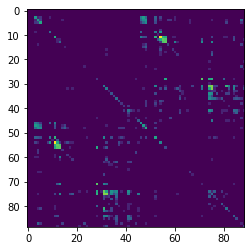

In [118]:
import numpy as np
import matplotlib.pyplot as plt
plt.imshow(np.log1p(M), interpolation='nearest')
plt.savefig("connectivity.png")

In our example track, there are more streamlines connecting regions 11 and 54 than any other pair of regions. These labels represent the left and right superior frontal gyrus respectively. These two regions are large, close together, have lots of corpus callosum fibers and are easy to track so this result should not be a surprise to anyone.

However, the interpretation of streamline counts can be tricky. The relationship between the underlying biology and the streamline counts will depend on several factors, including how the tracking was done, and the correct way to interpret these kinds of connectivity matrices is still an open question in the diffusion imaging literature.

## Compute density map

The next function we'll demonstrate is `density_map`. This function allows one to represent the spatial distribution of a track by counting the density of streamlines in each voxel.

For example, let's take the track connecting the left and right superior frontal gyrus.

In [119]:
lr_superiorfrontal_track = grouping[11, 54]
shape = labels.shape
dm = utils.density_map(lr_superiorfrontal_track, affine, shape)

Let's save this density map and visualize it

In [120]:
# Save density map
dm_img = nb.Nifti1Image(dm.astype("int16"), img.affine)

/home/quizhpilema.134643/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:531: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


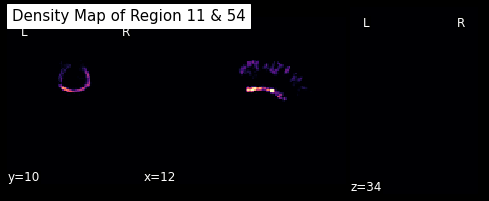

In [121]:
plotting.plot_anat(dm_img, cut_coords=[12,10,34], dim=-1, draw_cross=False,
                   cmap='magma', title='Density Map of Region 11 & 54')


# Direct Bundle Registration

Creating different tractographies is cool and looks very pleasing, but what if we want to compare the tractography of two people, where the bundles don't align? No worries, Dipy has the solution: **Bundle registration**

To show the concept we will use two pre-saved cingulum bundles.

In [122]:
from dipy.data import two_cingulum_bundles
cb_subj1, cb_subj2 = two_cingulum_bundles()

The algorithm we will be using is called Streamline-based Linear Registration (SLR) [Garyfallidis et al., 2015](https://www.sciencedirect.com/science/article/pii/S1053811915003961). An important step before running the registration is to resample the streamlines so that they both have the same number of points per streamline. Here we will use 20 points. This step is not optional. Inputting streamlines with different number of points will break the theoretical advantages of using the SLR.

In [123]:
from dipy.tracking.streamline import set_number_of_points
cb_subj1 = set_number_of_points(cb_subj1, 20)
cb_subj2 = set_number_of_points(cb_subj2, 20)

Let’s say now that we want to move the `cb_subj2` (moving) so that it can be aligned with `cb_subj1` (static). Here is how this is done:

In [124]:
from dipy.align.streamlinear import StreamlineLinearRegistration
srr = StreamlineLinearRegistration()

In [125]:
srm = srr.optimize(static=cb_subj1, moving=cb_subj2)

After the optimization is finished we can apply the transformation to `cb_subj2`.

In [126]:
cb_subj2_aligned = srm.transform(cb_subj2)

So let's visualize what we did:

In [127]:
from dipy.viz import window, actor
ren = window.Scene()
ren.SetBackground(1, 1, 1)

bundles = [cb_subj1, cb_subj2]
colors = [window.colors.orange, window.colors.red]
for (i, bundle) in enumerate(bundles):
        color = colors[i]
        lines_actor = actor.streamtube(bundle, color, linewidth=0.3)
        lines_actor.RotateX(-90)
        lines_actor.RotateZ(90)
        ren.add(lines_actor)

In [128]:
if view_mode == 'create_plot':
    window.record(ren, size=(600, 600),
                  out_path='data/diffusion/before_registration.png')
elif view_mode == 'interactive':
    window.show(ren)
Image(filename='data/diffusion/before_registration.png')

FileNotFoundError: [Errno 2] No such file or directory: 'data/diffusion/before_registration.png'

And now after bundle registration:

In [129]:
from dipy.viz import window, actor
ren = window.Scene()
ren.SetBackground(1, 1, 1)

bundles = [cb_subj1, cb_subj2_aligned]
colors = [window.colors.orange, window.colors.red]
for (i, bundle) in enumerate(bundles):
        color = colors[i]
        lines_actor = actor.streamtube(bundle, color, linewidth=0.3)
        lines_actor.RotateX(-90)
        lines_actor.RotateZ(90)
        ren.add(lines_actor)

In [130]:
if view_mode == 'create_plot':
    window.record(ren, size=(600, 600),
                  out_path='data/diffusion/after_registration.png')
elif view_mode == 'interactive':
    window.show(ren)
Image(filename='data/diffusion/after_registration.png')

FileNotFoundError: [Errno 2] No such file or directory: 'data/diffusion/after_registration.png'

As you can see the two cingulum bundles are well aligned although they contain many streamlines of different length and shape.